In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import pymysql
import datetime

In [2]:
def load_data(filetype='sql'):
    '''
    Loads the data from the given directory.
    Parameters:
    filetype: Defines which filetype to be read from, where the default is SQL.
    '''
    if filetype == 'sql':
        dbcon = pymysql.connect(user="root", password="example", database="humber_bridge", host="localhost", port=33061)
        data = pd.read_sql("SELECT * FROM SUMMARY", dbcon)
    elif filetype == 'csv':
        data = pd.read_csv('summary.csv')
    elif filetype == 'xlsx':
        data = pd.read_excel('quasi_static.xlsx')
    data.replace([1.1e+308], np.nan, inplace=True) # Replace infinite values with nan
    data.fillna(np.nan, inplace=True) # Replace empty cells with nan
    data.dropna(axis=1,how='all',inplace=True) # Remove empty columns (sensors with no data)
    data = data.replace([np.nan], 0) # Replace all nan values with 0
    return data

def OrdinalToDatetime(ordinal):
    try:
        plaindate = datetime.date.fromordinal(int(ordinal))
    except:
        plaindate = datetime.date.fromordinal(1)
    date_time = datetime.datetime.combine(plaindate, datetime.datetime.min.time())
    return date_time + datetime.timedelta(days=ordinal-int(ordinal))

def transform_timestamp(stamp):
        try:
            return OrdinalToDatetime(stamp/(24*3600*1000)).strftime('%d-%m-%Y %H:%M:%S.%f')
        except:
            return stamp

def convert_timestamp(data):
    timestamps = data[data.columns[0]].values
    data[data.columns[0]] = [transform_timestamp(time) for time in timestamps]
    data[data.columns[0]] = pd.to_datetime(data[data.columns[0]])
    return data

def create_training_data(df):
    '''
    Create the training data from the original dataframe.
    Parameters:
    df: The dataframe for which the training data will be created.
    Returns:
    training_data: The training data dataframe.
    '''
    training_data = df.select_dtypes(include=np.number)
    training_data = (training_data - training_data.mean())/training_data.std()
    return training_data

In [3]:
# Load the data from the database
data_df = load_data('csv')

# Convert the timestamp to a more readable style if wanted
data_df = convert_timestamp(data_df)

# Create the training data from the original dataframe
training_data = create_training_data(data_df)

In [4]:
# Create the autoencoder model to be used.

# Defines the size of the first layer of the autoencoder, which has to be equal to the length of the data.
size = training_data.shape[1]

class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(size, size//2),
            nn.ReLU(True),
            nn.Linear(size//2, size//4),
            nn.ReLU(True),
            nn.Linear(size//4, 4)
        ).to(device)
        self.decoder = nn.Sequential(
            nn.Linear(4, size//4),
            nn.ReLU(True),
            nn.Linear(size//4, size//2),
            nn.ReLU(True),
            nn.Linear(size//2, size)
        ).to(device)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
# Define the parameters for the model
num_epochs=100
batch_size=100
learning_rate=1e-3
# Using a GPU which supports CUDA will make training the model faster
device = torch.device('cpu')#'cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the training/testing data into tensors for the model
training_tensor_data = torch.from_numpy(training_data[:10000].values.astype(np.float32)).to(device)
testing_tensor_data = torch.from_numpy(training_data[10000:].values.astype(np.float32)).to(device)
load = DataLoader(training_tensor_data, batch_size=batch_size, shuffle=False)

In [6]:
# Load the model and set it into training mode
model = AutoEncoder().to(device)
loss_func = nn.MSELoss().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
model.train()

# Create a list to track the loss at each epoch
loss_list = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for idx, item in enumerate(load):
        optimiser.zero_grad()
        output = model(item.to(device))
        loss = loss_func(output, item)
        
        loss.backward()
        optimiser.step()

        epoch_loss += loss.item()
    print('Epoch %d, Loss = %f' %(epoch+1, epoch_loss))
    loss_list.append(epoch_loss)

Epoch 1, Loss = 30.746464
Epoch 2, Loss = 16.208394
Epoch 3, Loss = 4.974387
Epoch 4, Loss = 4.141730
Epoch 5, Loss = 4.035617
Epoch 6, Loss = 3.933689
Epoch 7, Loss = 3.819536
Epoch 8, Loss = 3.703079
Epoch 9, Loss = 3.417152
Epoch 10, Loss = 3.003298
Epoch 11, Loss = 2.654608
Epoch 12, Loss = 2.369899
Epoch 13, Loss = 2.129003
Epoch 14, Loss = 1.948111
Epoch 15, Loss = 1.847745
Epoch 16, Loss = 1.798962
Epoch 17, Loss = 1.770252
Epoch 18, Loss = 1.752520
Epoch 19, Loss = 1.739865
Epoch 20, Loss = 1.729434
Epoch 21, Loss = 1.723740
Epoch 22, Loss = 1.717956
Epoch 23, Loss = 1.714089
Epoch 24, Loss = 1.710951
Epoch 25, Loss = 1.705648
Epoch 26, Loss = 1.699983
Epoch 27, Loss = 1.692664
Epoch 28, Loss = 1.685241
Epoch 29, Loss = 1.680402
Epoch 30, Loss = 1.677223
Epoch 31, Loss = 1.669292
Epoch 32, Loss = 1.666955
Epoch 33, Loss = 1.661428
Epoch 34, Loss = 1.655452
Epoch 35, Loss = 1.647644
Epoch 36, Loss = 1.640878
Epoch 37, Loss = 1.632335
Epoch 38, Loss = 1.628397
Epoch 39, Loss = 1.

In [7]:
# This cell will save the model to a file
torch.save(model.state_dict(), 'ae_model')

In [8]:
# Uncomment below line to load the model from a file
#model.load_state_dict(torch.load('ae_model'))

model.eval()
loss_list = []
for i in range(len(testing_tensor_data)):
    data = testing_tensor_data[i]
    sample = model(data.to(device))
    loss = loss_func(data.to(device), sample)
    loss_list.append(loss.item())

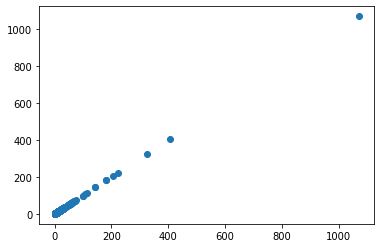

In [9]:
loss_sc = []
for i in loss_list:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))

In [10]:
# Create the test data in reference to the original dataframe
test_data = data_df[10000:]

# This parameter controls how sensitive the anomaly detection is: a bigger number will make the detection less sensitive
anomaly_sensitivity = 1

# Find the indices where the reconstruction loss is higher than the mean plus a number of standard deviations
indices = np.argwhere(np.array(loss_list)>np.mean(loss_list)+anomaly_sensitivity*np.std(loss_list)).reshape(-1)

anomaly_df = test_data.iloc[indices]

In [11]:
anomaly_df

,timestamp,TSH000ED,TSH000WD,TSH000CDT,TSH000CDB,HBB_WIH000CDS,HBB_WIH000CDD,HBB_TSH000CDA,HBB_TSH000CDG,HBB_TSH000CDS,...,DAMP_TS2,DAMP_LS1,DAMP_LS2a,DAMP_LS2c,DAMP_LA2b,DAMP_LS2d,WIM_GROSS,SCADA_AIR_TEMPERATURE,SCADA_WIND_SPEED,SCADA_WIND_DIRECTION
11415,2012-09-03 06:00:00.000000,0.0,0.0,0.0,0.0,13.915926,183.966716,6.506667,5.480000,5.460000,...,0.588445,1.639465,1.664886,0.549880,0.598941,1.420498,0.0,0.000000,0.000000,0.000000
11465,2012-10-03 06:59:59.999997,0.0,0.0,0.0,0.0,17.579259,202.500000,9.120000,8.113333,8.093333,...,0.683658,3.680078,2.543524,0.627785,0.268196,1.250381,0.0,0.000000,0.000000,0.000000
11466,2012-10-03 07:30:00.000000,0.0,0.0,0.0,0.0,18.328889,202.500000,9.210000,8.320000,8.360000,...,0.592397,1.506033,0.831725,0.869812,0.471212,1.625979,0.0,0.000000,0.000000,0.000000
11467,2012-10-03 08:00:00.000003,0.0,0.0,0.0,0.0,18.835556,202.500000,9.340000,8.793333,9.126667,...,0.801230,2.052707,2.243794,0.322548,0.662307,1.452952,0.0,0.000000,0.000000,0.000000
11468,2012-10-03 08:29:59.999997,0.0,0.0,0.0,0.0,19.422222,202.500000,9.373333,9.460000,10.093333,...,0.741370,2.346723,1.338426,0.468897,0.513461,1.615976,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57654,2014-10-28 13:30:00.000000,15.9,16.0,16.1,14.8,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.853462,1.066944,1.613125,0.513600,0.370820,1.295129,0.0,8.649977,2.661531,80.511327
57961,2014-03-11 23:00:00.000003,8.3,8.3,9.1,8.9,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.789894,1.632652,1.588489,0.490687,0.471976,1.415860,0.0,5.561041,1.711090,51.760459
57967,2014-04-11 02:00:00.000003,7.9,7.7,8.6,8.4,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.807372,1.595541,2.090984,0.366153,0.479900,1.491727,0.0,5.500671,1.692514,51.198553
58795,2014-11-21 08:00:00.000003,4.5,4.4,4.7,4.7,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.449318,3.092219,1.246116,0.521094,0.346408,1.206187,0.0,0.000000,0.000000,0.000000


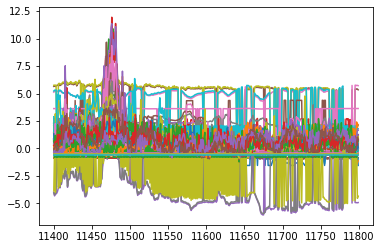

In [19]:
plt.plot(training_data[11400:11800])
plt.show()